### Machine Learning with Bank Marketing Dataset Notebook
This notebook explores the application of machine learning techniques to the Bank Marketing dataset, a popular dataset in machine learning, particularly for classification tasks. It's often used to practice and demonstrate techniques related to predicting customer behavior, specifically in the context of marketing campaigns.

The dataset originates from a Portuguese banking institution and is related to direct marketing campaigns (phone calls). The goal is to predict whether a customer will subscribe to a term deposit (a type of savings account) after being contacted by the bank.

The dataset contains information about customers, their demographics, financial status, and the outcomes of marketing campaigns. It includes a mix of numerical and categorical features. Here are some of the key attributes:

- age: Age of the customer (numeric)
- job: Type of job (categorical, e.g., 'admin.', 'blue-collar', 'management')
- marital: Marital status (categorical, e.g., 'married', 'single', 'divorced')
- education: Education level (categorical, e.g., 'high school', 'university degree')
- default: Has credit in default? (categorical, 'yes', 'no')
- housing: Has housing loan? (categorical, 'yes', 'no')
- loan: Has personal loan? (categorical, 'yes', 'no')
- contact: Contact communication type (categorical, e.g., 'cellular', 'telephone')   
- month: Last contact month of year (categorical, e.g., 'jan', 'feb', ..., 'dec')
- day_of_week: Last contact day of the week (categorical, e.g., 'mon', 'tue', ..., 'fri')
- duration: Last contact duration, in seconds (numeric) - Note: This feature is often excluded from realistic predictive models because it's only known after the call is made.
- campaign: Number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: Number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: Number of contacts performed before this campaign and for this client (numeric)   
- poutcome: Outcome of the previous marketing campaign (categorical, e.g., 'failure', 'success')   
- y: Has the client subscribed a term deposit? (binary, 'yes', 'no') - This is the target variable.

Throughout this notebook, we will use HeatWave AutoML to predict whether a customer will subscribe to a term deposit based on their characteristics and past interactions with the bank.

### Prerequistises
Install the necessary packages

- mysql-connector-python
- pandas 
- scikit-learn
- sqlalchemy

In [1]:
import json
import os
import zipfile
import mysql.connector
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import sqlalchemy

### Connect to the HeatWave instance
We create a connection to an active [HeatWave](https://www.oracle.com/mysql/) instance using the [MySQL Connector/Python](https://dev.mysql.com/doc/connector-python/en/). We also define an API to execute a SQL query using a cursor, and the result is returned as a Pandas DataFrame. Modify the below variables to point to your HeatWave instance. On AWS, set USE_BASTION to False. On OCI, please create a tunnel on your machine using the below command by substituting the variable with their respective values

ssh -o ServerAliveInterval=60 -i BASTION_PKEY -L LOCAL_PORT:DBSYSTEM_IP:DBSYSTEM_PORT BASTION_USER@BASTION_IP

In [ ]:
BASTION_IP ="ip_address"
BASTION_USER = "opc"
BASTION_PKEY = "private_key_file"
DBSYSTEM_IP = "ip_address"
DBSYSTEM_PORT = 3306
DBSYSTEM_USER = "username"
DBSYSTEM_PASSWORD = "password"
DBSYSTEM_SCHEMA = "mlcorpus"
LOCAL_PORT = 3306
USE_BASTION = True

if USE_BASTION is True:
    DBSYSTEM_IP = "127.0.0.1"
else:
    LOCAL_PORT = DBSYSTEM_PORT

mydb = mysql.connector.connect(
    host=DBSYSTEM_IP,
    port=LOCAL_PORT,
    user=DBSYSTEM_USER,
    password=DBSYSTEM_PASSWORD,
    database=DBSYSTEM_SCHEMA,
    allow_local_infile=True,
    use_pure=True,
    autocommit=True,
)
mycursor = mydb.cursor()


# Helper function to execute SQL queries and return the results as a Pandas DataFrame
def execute_sql(sql: str) -> pd.DataFrame:
    mycursor.execute(sql)
    return pd.DataFrame(mycursor.fetchall(), columns=mycursor.column_names)

 ### Download the Bank Marketing dataset and load it into Python
 We download the bank marketing dataset from [UCI](https://archive.ics.uci.edu/). We extract the zipfile, and load into Python using Pandas.

In [3]:
# Download the bank marketing dataset to a local folder
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
# Extract the dataset. This creates 3 files: bank.csv, bank-full.csv and bank-names.txt
zipfile.ZipFile("bank.zip", "r").extractall()

# Create a Pandas dataframe from the data
df = pd.read_csv("bank-full.csv", header=0, sep=";", encoding="utf-8")

# Now that we have loaded the data in Python, we don't need the local files anymore
os.remove("bank.zip")
os.remove("bank.csv")
os.remove("bank-full.csv")
os.remove("bank-names.txt")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  565k    0  565k    0     0   341k      0 --:--:--  0:00:01 --:--:--  341k


### Split the data into a training set and an evaluation set
In machine learning, the train-test split is a crucial technique used to evaluate the performance of a model on unseen data. It involves dividing the available dataset into two distinct subsets:   

- Training set: This subset is used to train the machine learning model. The model learns the underlying patterns and relationships in the data by analyzing this set.   
- Test set: This subset is held back and not used during the training process. Once the model is trained, it's applied to the test set to assess its ability to generalize to new, unseen data.

In [4]:
df_train, df_test = train_test_split(
    df, test_size=0.30, random_state=1, stratify=df["y"]
)
df_train = df_train.replace({np.nan: "NULL"})
df_test = df_test.replace({np.nan: "NULL"})

 ### Load the Bank Marketing dataset into a HeatWave table
 We connect to the MySQL database using SQLAlchemy, map Pandas data types to their corresponding MySQL dialects, and writes two DataFrames (df_train and df_test) to separate tables (bank_marketing_train and bank_marketing_test) in the database, replacing any existing tables.

In [ ]:
# Create a SQLAlchemy engine instance to connect to the MySQL database
sql_engine = sqlalchemy.create_engine(
    f"mysql+mysqlconnector://{DBSYSTEM_USER}:{DBSYSTEM_PASSWORD}@{DBSYSTEM_IP}:{LOCAL_PORT}/{DBSYSTEM_SCHEMA}",
    echo=False,
    echo_pool=False,
    pool_pre_ping=True,
    pool_recycle=3600,
)

# Define a dictionary mapping pandas data types to their corresponding SQLAlchemy dialects
dtype_mapping = {
    "uint64": sqlalchemy.dialects.mysql.INTEGER(unsigned=True),
    "int64": sqlalchemy.dialects.mysql.INTEGER(),
    "float64": sqlalchemy.dialects.mysql.FLOAT(),
    "object": sqlalchemy.dialects.mysql.VARCHAR(length=255),
    "datetime64[ns]": sqlalchemy.dialects.mysql.DATETIME(timezone=False),
    "bool": sqlalchemy.dialects.mysql.TINYINT(),
}
# Prepare the dtype dict for sqlalchemy/pd.DataFrame.to_sql
dtypes = {col: dtype_mapping[str(dtype)] for col, dtype in zip(df.columns, df.dtypes)}

# Write the training DataFrame to the 'bank_marketing_train' table in the database
df_train.to_sql(
    f"bank_marketing_train",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=5000,
    index=False,
)
# Write the testing DataFrame to the 'bank_marketing_test' table in the database
df_test.to_sql(
    f"bank_marketing_test",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=5000,
    index=False,
)

13564

### Create a HeatWave AutoML model from the Bank Marketing training dataset
We create a machine learning model on the Bank Marketing dataset using the [ML_TRAIN](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-train.html) API. The column y in the data contains whether the customer subscribes to a term deposit. We specify y as the column that we are trying to learn on, since we need to predict for new sample what the value of y will be. The model handle generated at the end of training is stored in the model variable. We will use this handle to refer to the model in our future interactions

In [6]:
execute_sql("""SET @model = NULL;""")
execute_sql(
    f"""CALL sys.ML_TRAIN('{DBSYSTEM_SCHEMA}.bank_marketing_train', 'y', NULL, @model)"""
)
model = execute_sql("""SELECT @model;""").iat[0,0]
execute_sql(f"""CALL sys.ML_MODEL_LOAD('{model}', NULL)""")

""


### Evaluate the model
We look at the overall performance of the model on unseen data by using the [ML_SCORE](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-score.html) routine to compute the accuracy. The accuracy metric tells us what percentage of predictions the model answered correctly on the bank_marketing_test data.

In [7]:
execute_sql(
    f"""CALL sys.ML_SCORE('{DBSYSTEM_SCHEMA}.bank_marketing_test', 'y', '{model}', 'accuracy', @score, NULL);"""
)
score = execute_sql("""SELECT @score;""").iat[0,0]
print(f"The model accuracy is {score*100:.2f}")

The model accuracy is 90.73


### Generating predictions to evaluate model performance on unseen test data
We invoke the [ML_PREDICT_TABLE](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-predict-table.html) API to generate prediction for the above model on our test data. The output table contains 2 extra columns 
- Prediction: Contains the actual prediction from the model. This is what the model thinks the customer will do based on the data it has learned from earlier.
- ml_results: This contains more details about the prediction

In [8]:
execute_sql(f"""DROP TABLE IF EXISTS bank_marketing_test_predictions""")
execute_sql(
    f"""CALL sys.ML_PREDICT_TABLE('{DBSYSTEM_SCHEMA}.bank_marketing_test', '{model}', '{DBSYSTEM_SCHEMA}.bank_marketing_test_predictions', NULL)"""
)
df_predictions = execute_sql(f"""SELECT * FROM bank_marketing_test_predictions""")
execute_sql(f"""DROP TABLE IF EXISTS bank_marketing_test_predictions""")
df_predictions.head()

,_4aad19ca6e_pk_id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,Prediction,ml_results
0,1,30,services,married,secondary,no,7032,no,no,cellular,17,jul,102,1,-1,0,unknown,no,no,"{""predictions"": {""y"": ""no""}, ""probabilities"": ..."
1,2,34,management,married,tertiary,no,676,no,no,telephone,11,nov,486,1,-1,0,unknown,yes,yes,"{""predictions"": {""y"": ""yes""}, ""probabilities"":..."
2,3,34,blue-collar,single,secondary,no,869,no,no,cellular,31,aug,89,1,-1,0,unknown,no,no,"{""predictions"": {""y"": ""no""}, ""probabilities"": ..."
3,4,38,housemaid,married,secondary,no,-278,yes,no,cellular,28,jul,143,2,-1,0,unknown,no,no,"{""predictions"": {""y"": ""no""}, ""probabilities"": ..."
4,5,32,admin.,single,tertiary,no,594,yes,no,unknown,13,may,134,2,-1,0,unknown,no,no,"{""predictions"": {""y"": ""no""}, ""probabilities"": ..."


### Getting a deeper understanding of the model's predictions

Evaluating a classification model is slightly more involved. Essentially we would like to know when the model was wrong and when the model was right. We use a [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to help us visualize the model's behavior.

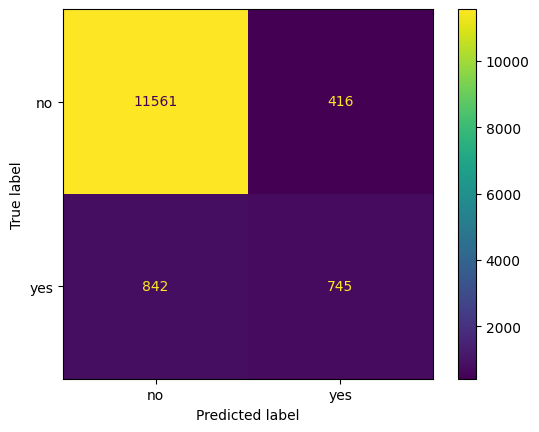

In [9]:
ConfusionMatrixDisplay.from_predictions(
    df_predictions["y"], df_predictions["Prediction"]
)

### Model explanations

HeatWave AutoML also provides [model explanations](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-model-viewing.html) which provide a global view of which columns contributed the most to create the model. The duration of the call is the most important predictor for whether a customer will subscribe to a term deposit, which makes sense since the longer the customer is engaged, the higher the chances of them liking the product.

<Axes: >

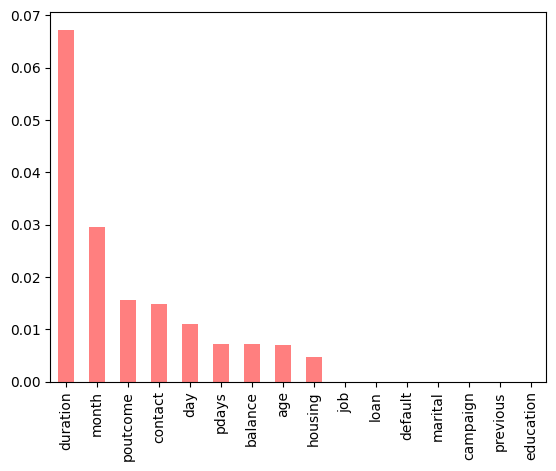

In [10]:
df = execute_sql(
    f"""SELECT model_explanation FROM ML_SCHEMA_{DBSYSTEM_USER}.MODEL_CATALOG WHERE model_handle = '{model}'"""
)
pd.Series(json.loads(df.iat[0,0])["permutation_importance"]).sort_values(
    axis=0, ascending=False
).plot(kind="bar", color="r", alpha=0.5)

We invite you to try [HeatWave AutoML and GenAI](https://www.oracle.com/heatwave/free/). If you’re new to Oracle Cloud Infrastructure, try Oracle Cloud Free Trial, a free 30-day trial with US$300 in credits.